In [16]:
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
import random
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Importando a base com observações georrefeciadas de incêndios em vegetação na Região Metropolitana de Maceió entre 2018 e 2020.

os.chdir('diretório da base de dados')
os.listdir()

basedia = pd.read_excel('BASE RM COUNT DIA1.xlsx')

X = basedia[['PRECIPITACAO', 'PRESSAO_AT',  'UMIDADE_RELATIVA', 'TEMPERATURA_PONTO_ORVALHO', 'VEL_VENTO', 'VERÃO', 'INVERNO', 
          'JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'LAG_PRECIPITACAO',
          'LAG_TEMPERATURA_PONTO_ORVALHO', 'LAG_UMIDADE_RELATIVA', 'LAG_PRESSAO_AT' ]]

y = basedia[['INCENDIO1']]

In [18]:
# definindo base de treino e base de teste
random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [19]:
## Random Forest para selecionar variáveis
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, min_samples_split=3, random_state=0))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)

Index(['PRECIPITACAO', 'PRESSAO_AT', 'UMIDADE_RELATIVA',
       'TEMPERATURA_PONTO_ORVALHO', 'VEL_VENTO', 'LAG_PRECIPITACAO',
       'LAG_TEMPERATURA_PONTO_ORVALHO', 'LAG_UMIDADE_RELATIVA',
       'LAG_PRESSAO_AT'],
      dtype='object')


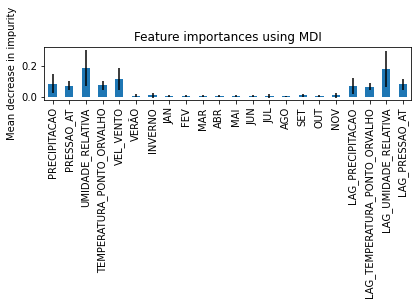

In [9]:
### gráficos de importância de variáveis

feature_names = ['PRECIPITACAO', 'PRESSAO_AT',  'UMIDADE_RELATIVA', 'TEMPERATURA_PONTO_ORVALHO', 'VEL_VENTO', 'VERÃO', 'INVERNO', 
                 'JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'LAG_PRECIPITACAO',
                 'LAG_TEMPERATURA_PONTO_ORVALHO', 'LAG_UMIDADE_RELATIVA', 'LAG_PRESSAO_AT' ]
forest = RandomForestClassifier(n_estimators = 100, min_samples_split=3, random_state=0)
forest.fit(X_train, y_train)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.tight_layout()

In [20]:
## Regressão logística

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg.intercept_

## acurácia
print('Acurácia do modelo de regressão logística na base de teste: {:.2f}'.format(logreg.score(X_test, y_test)))

Acurácia do modelo de regressão logística na base de teste: 0.86


In [21]:
## matriz de confusão e algumas métricas
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

print(classification_report(y_test, y_pred))

[[126  12]
 [ 18  57]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       138
           1       0.83      0.76      0.79        75

    accuracy                           0.86       213
   macro avg       0.85      0.84      0.84       213
weighted avg       0.86      0.86      0.86       213



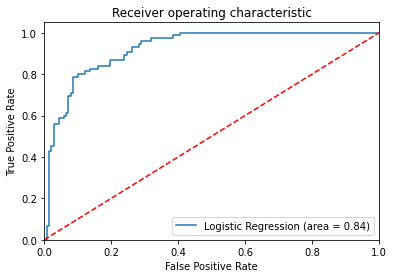

In [22]:
## Curva ROC

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [23]:
## regressão logit com base completa e efeitos marginais para observar algumas correlações
X = sm.add_constant(X)
logit_model=sm.Logit(y,X)

result=logit_model.fit()

print(result.summary2())

print(result.get_margeff(at ='mean').summary()) 

Optimization terminated successfully.
         Current function value: 0.387395
         Iterations 9
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.410      
Dependent Variable:      INCENDIO1            AIC:                  871.1505   
Date:                    2021-12-31 00:17     BIC:                  985.4773   
No. Observations:        1065                 Log-Likelihood:       -412.58    
Df Model:                22                   LL-Null:              -699.60    
Df Residuals:            1042                 LLR p-value:          2.4090e-107
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          9.0000                                                
-------------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025   0.975] 
---------------------------------------------------